# ***LLM & VECTOR DATABASE CHALLENGE***

In [1]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 38.1 MB/s eta 0:00:00


In [31]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer, util
import faiss
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import pipeline
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from datetime import datetime
from collections import Counter

In [3]:
# Loading the reviews dataset
reviews_df = pd.read_csv('product_reviews.csv')
# Previewing the first five records
reviews_df.head()

,review_id,product,category,rating,review_text,feature_mentioned,attribute_mentioned,date,sentiment
0,REV14165,TechPro X20,Smartphones,4,The TechPro X20 is amazing! facial recognition...,facial recognition,design,2023-03-09,positive
1,REV81426,TechPro X20,Smartphones,4,The TechPro X20 is amazing! battery life works...,battery life,design,2023-10-28,positive
2,REV54597,SmartWatch Pro,Wearables,4,The SmartWatch Pro is amazing! app integration...,app integration,durability,2023-03-09,positive
3,REV89131,SmartSpeaker 360,Smart Home,4,Very impressed with the SmartSpeaker 360. Grea...,app interface,connectivity,2022-12-19,positive
4,REV92397,HomeConnect Hub,Smart Home,4,Very impressed with the HomeConnect Hub. Great...,device compatibility,design,2022-10-28,positive


# Document Processing Pipeline

## Creating pipeline that extracts key information

In [4]:
# Loading spaCy model
nlp = spacy.load('en_core_web_sm')
# Data Preprocessing: Cleaning and standardizing the review text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

reviews_df['cleaned_review_text'] = reviews_df['review_text'].apply(clean_text)

# Ratings Trends: Calculate average ratings and sentiment distribution by category
ratings_trends = reviews_df.groupby('category').agg({
    'rating': ['mean', 'count'],  # Average rating and review count
    'sentiment': lambda x: x.value_counts().to_dict()  # Sentiment distribution
}).reset_index()

# Rename columns for clarity
ratings_trends.columns = ['Category', 'Average_Rating', 'Review_Count', 'Sentiment_Distribution']

# Display Ratings Trends
print("Ratings Trends:")
print(ratings_trends)

# Use spaCy for tokenization and POS tagging
def extract_theme_phrases(reviews, n=20):
    theme_phrases = Counter()
    for text in reviews:
        doc = nlp(text)
        # Extract adjective-noun pairs
        for token in doc:
            if token.pos_ == 'ADJ' and token.head.pos_ == 'NOUN':
                theme_phrases[f"{token.text} {token.head.text}"] += 1
    return theme_phrases.most_common(n)

# Separate reviews by sentiment
positive_reviews = reviews_df[reviews_df['sentiment'] == 'positive']['cleaned_review_text']
negative_reviews = reviews_df[reviews_df['sentiment'] == 'negative']['cleaned_review_text']

# Extract common praise (positive sentiment)
common_praise = extract_theme_phrases(positive_reviews, n=10)

# Extract common complaints (negative sentiment)
common_complaints = extract_theme_phrases(negative_reviews, n=10)

# Display Results
print("\nCommon Praise (Positive Sentiment):")
for phrase, count in common_praise:
    print(f"{phrase}: {count} mentions")

print("\nCommon Complaints (Negative Sentiment):")
for phrase, count in common_complaints:
    print(f"{phrase}: {count} mentions")


Ratings Trends:
      Category  Average_Rating  Review_Count  \
0        Audio        3.708738           206   
1      Laptops        3.791262           206   
2   Smart Home        3.755319           188   
3  Smartphones        3.641791           201   
4    Wearables        3.788945           199   

                             Sentiment_Distribution  
0  {'positive': 118, 'neutral': 48, 'negative': 40}  
1  {'positive': 125, 'neutral': 49, 'negative': 32}  
2  {'positive': 103, 'neutral': 58, 'negative': 27}  
3  {'positive': 115, 'neutral': 48, 'negative': 38}  
4  {'positive': 123, 'neutral': 50, 'negative': 26}  

Common Praise (Positive Sentiment):
facial recognition: 25 mentions
best audio: 24 mentions
homeconnect hub: 23 mentions
best laptops: 23 mentions
amazing life: 21 mentions
bassboost speaker: 21 mentions
sleepanalyzer band: 21 mentions
best wearables: 20 mentions
smart home: 19 mentions
best smartphones: 19 mentions

Common Complaints (Negative Sentiment):
fast chargi

Features like facial recognition (25 mentions), best audio (24 mentions), and homeconnect hub (23 mentions) are highlights.

These indicate customers are particularly satisfied with performance and technological innovations in specific products.

Category Standouts are observed such as best laptops (23 mentions), best wearables (20 mentions), and best smartphones (19 mentions), and receive consistent praise, suggesting strong competitive advantages in these categories.




Complaints about poor performance (6 mentions) and terrible performance (6 mentions) highlight dissatisfaction with the reliability or efficiency of some products.

Bassboost speaker (5 mentions), despite being praised, also appears in complaints—suggesting inconsistencies in user experience.



Terrible quality (7 mentions) and terrible design (6 mentions) reflect frustrations with durability or build quality.

## Generating embeddings, storing and retrieving reviews

In [5]:
# Initializing SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient and accurate embedding model

# Step 1: Generating embeddings for each review
def generate_embeddings(reviews):
    """
    Generate embeddings for each review using SentenceTransformer.
    Args:
        reviews (pd.Series): Series of review text.
    Returns:
        np.array: Array of embeddings (n_reviews x embedding_dim).
    """
    embeddings = model.encode(reviews.tolist(), convert_to_tensor=False, show_progress_bar=True)
    return np.array(embeddings)

# Generating embeddings
review_embeddings = generate_embeddings(reviews_df['review_text'])

# Saving embeddings to a file for reuse
np.save('review_embeddings.npy', review_embeddings)

# Step 2: Building FAISS index for storing embeddings
def build_faiss_index(embeddings):
    """
    Build a FAISS index to store embeddings for similarity search.
    Args:
        embeddings (np.array): Array of embeddings (n_reviews x embedding_dim).
    Returns:
        faiss.IndexFlatL2: FAISS index for similarity search.
    """
    embedding_dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(embedding_dim)  # Uses L2 (Euclidean) distance metric
    index.add(embeddings.astype('float32'))  # Ensures embeddings are in float32 format
    return index

# Building FAISS index
faiss_index = build_faiss_index(review_embeddings)

# Step 3: Retrieving reviews based on semantic similarity
def retrieve_similar_reviews(query, top_k=5):
    """
    Retrieve reviews semantically similar to the input query.
    Args:
        query (str): Query string to find similar reviews.
        top_k (int): Number of similar reviews to retrieve.
    Returns:
        pd.DataFrame: DataFrame of similar reviews with similarity scores.
    """
    # Generating embedding for the query
    query_embedding = model.encode([query], convert_to_tensor=False)
    query_embedding = np.array(query_embedding).astype('float32')  # Ensure compatibility with FAISS

    # Searching FAISS index for top_k similar embeddings
    distances, indices = faiss_index.search(query_embedding, top_k)

    # Retrieving similar reviews
    similar_reviews = reviews_df.iloc[indices[0]].copy()
    similar_reviews['similarity'] = 1 - distances[0]  # Convert L2 distance to similarity score
    return similar_reviews[['review_id', 'review_text', 'similarity']]

# Trying a few words
query = "great battery life"
top_similar_reviews = retrieve_similar_reviews(query, top_k=5)
print("Top Similar Reviews:")
print(top_similar_reviews)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Top Similar Reviews:
    review_id                                        review_text  similarity
472  REV68373  After using the PowerLaptop 15 for three month...    0.228301
886  REV82764  I've been using MobiElite 10 for six months no...    0.189439
95   REV76698  After using the UltraBook Pro for a year, I wo...    0.187414
923  REV51674  After using the TechPro X20 for a year, I woul...    0.185510
877  REV68226  I've been using MobiElite 10 for a year now an...    0.169599


All retrieved reviews highlight battery performance as a strong point of the devices. Even though they don’t use the exact phrase "great battery life", the model identified semantically similar experiences, indicating that users consistently appreciate battery longevity.

# LLM Application

## Generating concise summaries of product performance

In [6]:
# Summarization of Product Performance by Category
def generate_category_summaries(reviews_df):
    """
    Generate concise summaries of product performance by category.
    Args:
        reviews_df (pd.DataFrame): DataFrame containing reviews and categories.
    Returns:
        dict: Dictionary of summaries by category.
    """
    summarization_pipeline = pipeline("summarization", model="facebook/bart-large-cnn")

    summaries = {}
    for category in reviews_df['category'].unique():
        # Combine all reviews of a category
        category_reviews = " ".join(reviews_df[reviews_df['category'] == category]['review_text'])
        # Limit text input to model (e.g., 1024 tokens max for BART)
        category_reviews = category_reviews[:1024]

        # Generate summary
        summary = summarization_pipeline(category_reviews, max_length=100, min_length=30, do_sample=False)
        summaries[category] = summary[0]['summary_text']

    return summaries

# Generate and display summaries
category_summaries = generate_category_summaries(reviews_df)
print("Category Summaries:")
for category, summary in category_summaries.items():
    print(f"{category}: {summary}")


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


Category Summaries:
Smartphones: The PixelView 7's build quality is awful and the fast charging keeps malfunctioning. The TechPro X20 is amazing! facial recognition works perfectly and the design is outstanding. Disappointed with the GalaxyWave S5.
Wearables: The SmartWatch Pro is amazing! app integration works perfectly and the durability is outstanding. Disappointed with the SleepAnalyzer Band. The app integration constantly fails and the accuracy is subpar.
Smart Home: Very impressed with the SmartSpeaker 360. Great connectivity and the app interface is exactly what I needed. The SecurityCam Pro was a waste of money.
Audio: NoiseCancel Headphones is amazing! battery life works perfectly and the comfort is outstanding. The StudioQuality Earbuds is decent. microphone works as expected but the build quality could be better.
Laptops: The DevBook 13 is amazing! trackpad works perfectly and the performance is outstanding. Disappointed with the MacStyle Air. The battery life constantly fai

## Creating a Q&A system

In [7]:
#  Q&A System
def question_answering_system(question, reviews_df):
    """
    Answer specific questions about products using review data.
    Args:
        question (str): User question.
        reviews_df (pd.DataFrame): DataFrame containing reviews and categories.
    Returns:
        str: Answer to the question.
    """
    qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

    # Combine all reviews into a context
    context = " ".join(reviews_df['review_text'])

    # Generate answer
    result = qa_pipeline(question=question, context=context)
    return result['answer']

# Example Q&A
question = "What do customers think about the battery life of smartphones?"
answer = question_answering_system(question, reviews_df)
print("\nQ&A Example:")
print(f"Question: {question}")
print(f"Answer: {answer}")

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu



Q&A Example:
Question: What do customers think about the battery life of smartphones?
Answer: Nothing exceptional


## common issues and praised features

# Sentiment Analysis & Classification

## classification system to detect sentiment

In [29]:
# Checking for class distribution
# Count the number of samples per sentiment class
class_counts = reviews_df['sentiment'].value_counts()
print("Class Counts:\n", class_counts)


Class Counts:
 sentiment
positive    584
neutral     253
negative    163
Name: count, dtype: int64


There is class imbalance, which should be handled

In [39]:
# Loading Precomputed Embeddings
review_embeddings = np.load('review_embeddings.npy')
print("Embeddings loaded successfully. Shape:", review_embeddings.shape)

# Train/Test Split
train_df, test_df = train_test_split(reviews_df, test_size=0.2, random_state=42)
X_train = review_embeddings[train_df.index]
y_train = train_df['sentiment']
X_test = review_embeddings[test_df.index]
y_test = test_df['sentiment']

# Handling Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("SMOTE applied successfully. Resampled shapes:")
print("X_train_smote:", X_train_smote.shape)
print("y_train_smote:", len(y_train_smote))

# Sentiment Classification Using RoBERTa
def classify_sentiments(reviews):
    """
    Classifies sentiments using a pre-trained RoBERTa-based model.
    Args:
        reviews (pd.Series): Series of review text.
    Returns:
        list: Predicted sentiment labels ('positive', 'neutral', 'negative').
    """
    sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")
    predictions = sentiment_pipeline(reviews.tolist(), truncation=True)
    labels = [result['label'].lower() for result in predictions]
    return labels

# Applying classification to the test data
test_df['predicted_sentiment'] = classify_sentiments(test_df['review_text'])




Embeddings loaded successfully. Shape: (1000, 384)
SMOTE applied successfully. Resampled shapes:
X_train_smote: (1401, 384)
y_train_smote: 1401


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Comparing classifier's results

In [41]:
# Evaluation
accuracy = accuracy_score(y_test, test_df['predicted_sentiment'])
precision = precision_score(y_test, test_df['predicted_sentiment'], average='weighted')
recall = recall_score(y_test, test_df['predicted_sentiment'], average='weighted')
f1 = f1_score(y_test, test_df['predicted_sentiment'], average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print("\nClassification Report:\n")
print(classification_report(y_test, test_df['predicted_sentiment']))



Accuracy: 0.735
Precision: 0.8168539713182571
Recall: 0.735
F1-Score: 0.6409616666386144

Classification Report:

              precision    recall  f1-score   support

    negative       0.55      1.00      0.71        27
     neutral       1.00      0.05      0.10        56
    positive       0.79      1.00      0.88       117

    accuracy                           0.73       200
   macro avg       0.78      0.68      0.57       200
weighted avg       0.82      0.73      0.64       200



## Visualization dashboard for sentiment trends

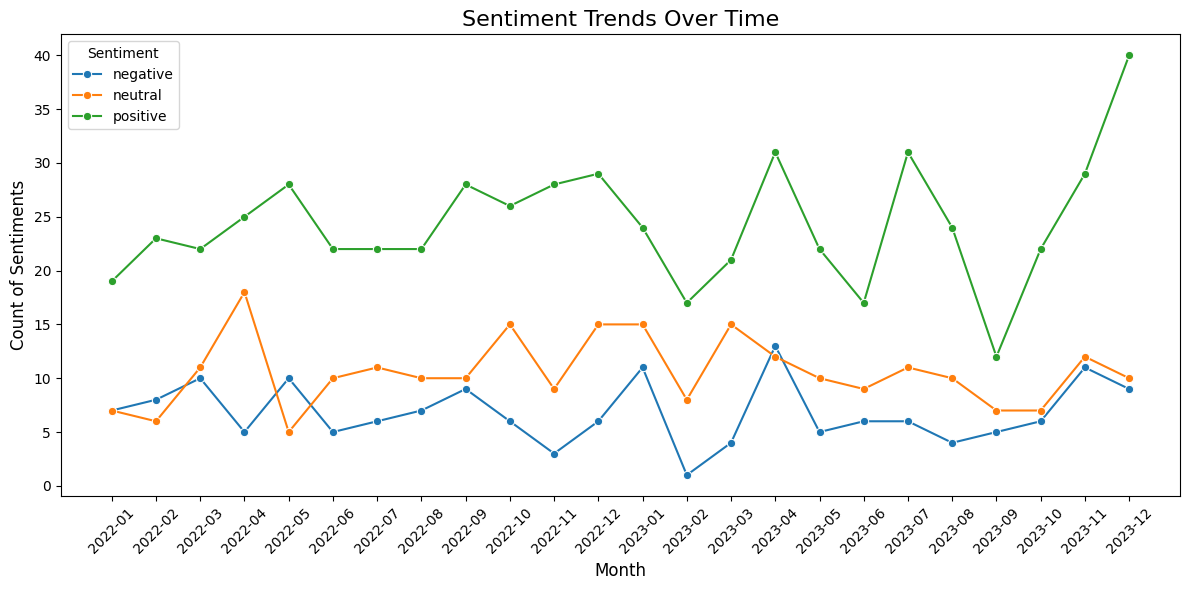

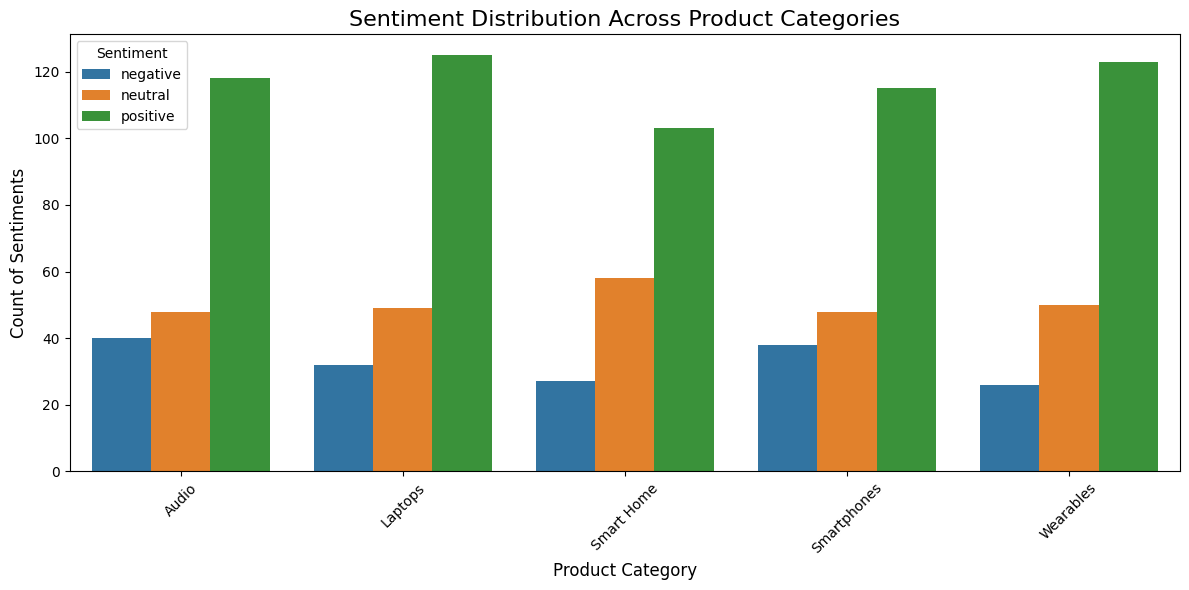

In [14]:
# Preprocess 'date' column and handle missing or invalid values
reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')
reviews_df = reviews_df.dropna(subset=['date'])  # Remove rows with invalid dates

# Extract the 'month' column for grouping
reviews_df['month'] = reviews_df['date'].dt.to_period('M')

# Sentiment trends over time
def plot_sentiment_trends(reviews_df):
    """
    Create a line plot for sentiment trends over time.
    """
    sentiment_trends = reviews_df.groupby(['month', 'sentiment']).size().reset_index(name='count')
    sentiment_trends['month'] = sentiment_trends['month'].astype(str)  # Convert month for plotting

    # Plot sentiment trends
    plt.figure(figsize=(12, 6))  # Correctly specify figure size
    sns.lineplot(data=sentiment_trends, x='month', y='count', hue='sentiment', marker='o')
    plt.title("Sentiment Trends Over Time", fontsize=16)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Count of Sentiments", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

# Sentiment distribution across categories
def plot_sentiment_distribution(reviews_df):
    """
    Create a bar plot for sentiment distribution across product categories.
    """
    sentiment_by_category = reviews_df.groupby(['category', 'sentiment']).size().reset_index(name='count')

    # Plot sentiment distribution across categories
    plt.figure(figsize=(12, 6))  # Correctly specify figure size
    sns.barplot(data=sentiment_by_category, x='category', y='count', hue='sentiment')
    plt.title("Sentiment Distribution Across Product Categories", fontsize=16)
    plt.xlabel("Product Category", fontsize=12)
    plt.ylabel("Count of Sentiments", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

# Generating the updated dashboard
plot_sentiment_trends(reviews_df)
plot_sentiment_distribution(reviews_df)


Positive sentiments are growing towards the end of 2023,
neutral sentiments remain stable and negative sentiments remain relatively low but slightly increase in late 2023.
The positive sentiments increasing toward the end of 2023,  suggests that customers are becoming more satisfied — maybe due to product improvements, better service, or successful marketing campaigns.

Since neutral sentiments are stable, it shows that a consistent portion of users are neither overly impressed nor disappointed — which is not bad, but also suggests opportunities to convert neutral customers into happy (positive) ones.

 The slight increase in negative sentiments toward late 2023 could be an early warning. It might hint at new problems (product defects, service issues, price dissatisfaction, etc.) starting to surface that the company should investigate and address quickly before they grow bigger.

Customers generally love the products across all categories.

Marketing teams can confidently highlight positive reviews when promoting Audio, Laptops, Smartphones, Smart Home devices, and Wearables.

Overall customer satisfaction is strong, creating opportunities for upselling and cross-selling.



Wearables (like smartwatches, fitness trackers) and Laptops seem to meet or even exceed customer expectations the most.
These are strong product lines — investment should be more in advertising these, bundling them with accessories, or even introducing premium upgrades. Could indicate greater brand loyalty in these two categories.

Smart Home Products Have the Lowest Positive Sentiment (But Still High Overall) Smart Home devices (like smart speakers, cameras, lights) are generally liked but slightly less enthusiastically than other categories. Possible reasons could include installation issues, connectivity problems, or complexity of use. Teams could focus on improving user experience (ease of setup, integration guides) to push positive sentiment higher.